## Setup

In [479]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import pandas as pd
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot the figures
import matplotlib as mlp 
import matplotlib.pyplot as plt
mlp.rc('axes', labelsize=14)
mlp.rc('xtick', labelsize=12)
mlp.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "../"
IMAGES_PATH = "images"
os.makedirs(IMAGES_PATH, exist_ok=True)

# Function to save the figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, figure=None):
    path = os.path.join(IMAGES_PATH, (fig_id + "." + fig_extension))
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()

    if figure is None:
        plt.savefig(path, format=fig_extension, dpi=resolution)
    else:
        figure.savefig(path, format=fig_extension, dpi=resolution)


## Get the  data

In [480]:
DATASETS_PATH = os.path.join(PROJECT_ROOT_DIR, 'datasets')
os.makedirs(DATASETS_PATH, exist_ok=True)

DATASET_NAME = 'dados 5-2.txt'

# columns names for the dataset
columns=['Distance','RSSI']

def load_data(data_path = DATASETS_PATH, dataset_name= DATASET_NAME, columns_names=columns):
    txt_path = os.path.join(data_path, dataset_name)
    return pd.read_table(txt_path, names=columns)

# read the dataset
data_5_2_Ghz = load_data(data_path=DATASETS_PATH, dataset_name=DATASET_NAME, columns_names=columns)
data_5_2_Ghz.head()
data_5_2_Ghz['Distance'] = np.log10(data_5_2_Ghz['Distance'])

Saving figure 1-RSSIxDistance


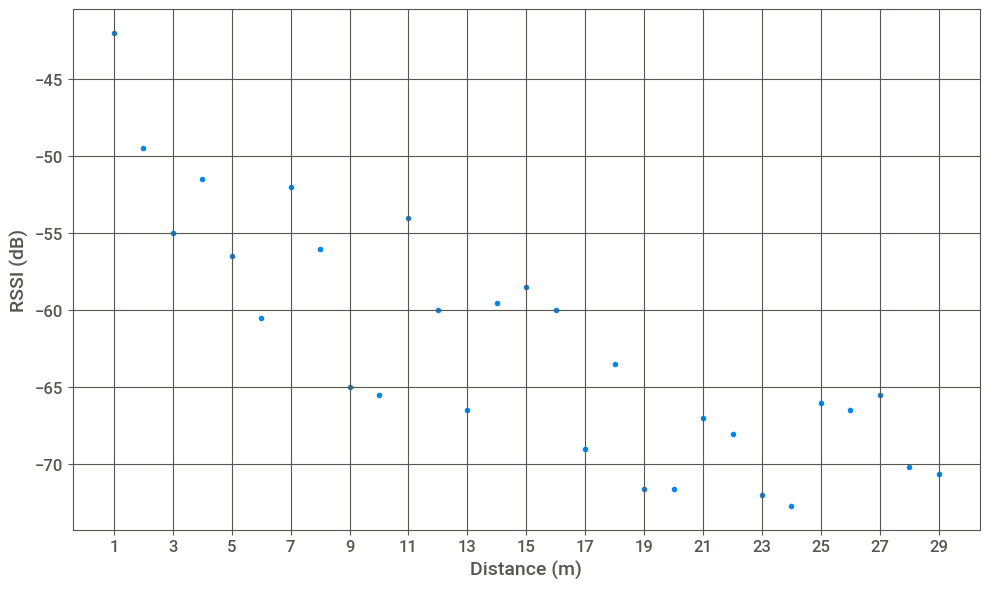

In [481]:
# Show the RSSI behavior in function of the distance
plt.figure(figsize=(10,6))
plt.scatter(10**data_5_2_Ghz['Distance'], data_5_2_Ghz['RSSI'], label='2.4 GHz')
plt.ylabel('RSSI (dB)')
plt.xlabel('Distance (m)')
plt.xticks(np.arange(1,30,2))
plt.grid()
save_fig('1-RSSIxDistance', fig_extension='png', resolution=300)
plt.show()

## Exploratory Data Analisys

In [482]:
import sweetviz as sv

# Analyzing the data
report = sv.analyze(data_5_2_Ghz)

# Generating the report
report.show_html('EDA/data_5_2_Ghz.html')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report EDA/data_5_2_Ghz.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Prepare the data for Machine Learning algorithms

In [483]:

from sklearn.model_selection import train_test_split

# Train test split
train_set, test_set = train_test_split(data_5_2_Ghz, test_size=0.2, random_state=7)

features = train_set.drop('RSSI', axis=1)
labels = train_set['RSSI'].values

### Tranformation Pipelines

In [484]:
# Create a pipeline to preprocess the data
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

numerical_pipeline = Pipeline([
        ("standardize", StandardScaler()),
])

In [485]:
from sklearn import set_config

# Show the pipeline in diagram
set_config(display='diagram')

numerical_pipeline

Pipeline(steps=[('standardize', StandardScaler())])

In [486]:
from sklearn.compose import ColumnTransformer

# Aplication of the pipeline
preprocessing = ColumnTransformer([
    ("num", numerical_pipeline, features.columns)
])

features_prepared = preprocessing.fit_transform(features)

# Create a dataframe to visualize the data after the preprocessing (optional)
df_features_prepared = pd.DataFrame(features_prepared, columns=features.columns, index=features.index)
df_features_prepared.head(2)

,Distance
18,0.43
23,0.73


## Select and Train a Model

In [487]:
from sklearn.linear_model import LinearRegression

# Logistic Regression model
lin_reg = Pipeline([
    ("preprocessing", preprocessing), 
    ("linear_regression", LinearRegression())
])

lin_reg.fit(features, labels)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  Index(['Distance'], dtype='object'))])),
                ('linear_regression', LinearRegression())])

In [488]:
from sklearn.linear_model import Lasso

# Lassso Regression model
lasso_reg = Pipeline([
    ("preprocessing", preprocessing), 
    ("lasso_regression", Lasso())
])
lasso_reg.fit(features, labels)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  Index(['Distance'], dtype='object'))])),
                ('lasso_regression', Lasso())])

In [489]:
from sklearn.tree import DecisionTreeRegressor

# Decision Tree model
tree_reg = Pipeline([
    ("preprocessing", preprocessing), 
    ("tree_regression", DecisionTreeRegressor(random_state=42))
])
tree_reg.fit(features, labels)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  Index(['Distance'], dtype='object'))])),
                ('tree_regression', DecisionTreeRegressor(random_state=42))])

In [490]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = Pipeline([
    ("preprocessing", preprocessing), 
    ("random_forest", RandomForestRegressor(random_state=42))
])
forest_reg.fit(features, labels)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  Index(['Distance'], dtype='object'))])),
                ('random_forest', RandomForestRegressor(random_state=42))])

### Evaluation using Cross-Validation

In [491]:
from sklearn. model_selection import cross_val_score

In [492]:
# Cross validation of the linear model
lin_rmses = -cross_val_score(lin_reg, features, labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count   10.00
mean     4.15
std      0.73
min      3.16
25%      3.61
50%      3.98
75%      4.63
max      5.40
dtype: float64

In [493]:
# Cross validation of the lasso model
lasso_rmses = -cross_val_score(lasso_reg, features, labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lasso_rmses).describe()

count   10.00
mean     4.18
std      0.96
min      2.65
25%      3.42
50%      4.16
75%      4.99
max      5.57
dtype: float64

In [494]:
# Cross validation of Tree model
tree_rmses = -cross_val_score(tree_reg, features, labels, scoring="neg_root_mean_squared_error", cv =10)
pd.Series(tree_rmses).describe()

count   10.00
mean     5.23
std      2.79
min      0.50
25%      4.44
50%      5.63
75%      7.20
max      8.87
dtype: float64

In [495]:
# Cross validation of the forest model
forest_rmses = -cross_val_score(forest_reg, features, labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count   10.00
mean    28.85
std     22.81
min      2.03
25%     14.17
50%     25.42
75%     43.62
max     71.96
dtype: float64

## Fine-Tune the Model

### Randomized Search

In [496]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Function to aply the randomized search in the models
def fine_tune_model(param_distribs, model, features, labels, cv=10, n_iter=100):
    rnd_search = RandomizedSearchCV(model, param_distributions=param_distribs, n_iter=n_iter, cv=cv, scoring='neg_root_mean_squared_error', random_state=42)
    display(rnd_search.fit(features, labels))
    
    return rnd_search

#### Lasso Model

In [497]:
lasso_param_distribs = {
    'lasso_regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100],
    'lasso_regression__max_iter': [1000, 5000, 10000],
    'lasso_regression__tol': [1e-4, 1e-3, 1e-2],
    'lasso_regression__fit_intercept': [True, False],
    'lasso_regression__selection': ['cyclic', 'random']
}

rnd_search_lasso = fine_tune_model(lasso_param_distribs, lasso_reg, features, labels, cv=10, n_iter=1000)
lasso_reg_best = rnd_search_lasso.best_estimator_
lasso_reg_best['lasso_regression']

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('standardize',
                                                                                                StandardScaler())]),
                                                                               Index(['Distance'], dtype='object'))])),
                                             ('lasso_regression', Lasso())]),
                   n_iter=1000,
                   param_distributions={'lasso_regression__alpha': [0.0001,
                                                                    0.001, 0.01,
                                                                    0.1, 1.0,
                                                                    10, 100],
                                        'lasso_regression__fit_intercept': [True,
                                                                            False],
                                        'lasso_regression__max_iter': [1000,
                                                                       5000,
                                                                       10000],
                                        'lasso_regression__selection': ['cyclic',
                                                                        'random'],
                                        'lasso_regression__tol': [0.0001, 0.001,
                                                                  0.01]},
                   random_state=42, scoring='neg_root_mean_squared_error')

Lasso(alpha=0.1)

#### Decision Tree Model

In [498]:
tree_param_distribs = {'tree_regression__min_samples_split': randint(low=2, high=10), 
                  'tree_regression__min_samples_leaf': randint(low=1, high=10),
                  'tree_regression__max_leaf_nodes': randint(low=10, high=100)}

rnd_search_tree = fine_tune_model(tree_param_distribs, tree_reg, features, labels, cv=10, n_iter=100)
tree_reg_best = rnd_search_tree.best_estimator_
tree_reg_best["tree_regression"]

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('standardize',
                                                                                                StandardScaler())]),
                                                                               Index(['Distance'], dtype='object'))])),
                                             ('tree_regression',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_iter=100,
                   param_distributions={'tree_regression__max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020D405E05D0>,
                                        'tree_regression__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020D416D1D90>,
                                        'tree_regression__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020D455A0350>},
                   random_state=42, scoring='neg_root_mean_squared_error')

DecisionTreeRegressor(max_leaf_nodes=71, min_samples_split=3, random_state=42)

#### Random Forest Model

In [499]:
forest_param_distribs = {'random_forest__n_estimators': randint(low=1, high=200), 
                  'random_forest__min_samples_split': randint(low=2, high=10), 
                  'random_forest__min_samples_leaf': randint(low=1, high=10),
                  'random_forest__max_leaf_nodes': randint(low=10, high=100)}

rnd_search_forest = fine_tune_model(forest_param_distribs, forest_reg, features, labels, cv=10, n_iter=100)
forest_reg_best = rnd_search_forest.best_estimator_
forest_reg_best["random_forest"]

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('standardize',
                                                                                                StandardScaler())]),
                                                                               Index(['Distance'], dtype='object'))])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=100,
                   param_distributions={'random_forest__max_leaf_nodes': <scipy.stats._distn_infrastruc...
                                        'random_forest__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020D427CA2D0>,
                                        'random_forest__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020D41B33A10>,
                                        'random_forest__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020D416FB610>},
                   random_state=42, scoring='neg_root_mean_squared_error')

RandomForestRegressor(max_leaf_nodes=78, min_samples_leaf=5,
                      min_samples_split=9, n_estimators=9, random_state=42)

## Evaluate the Model on the Test Set

In [500]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# The test set
X_test = test_set.drop('RSSI', axis=1)
y_test = test_set['RSSI'].copy()

### Linear Model Test

In [501]:
# Linear model prediction in the test set
lin_reg_prediction = lin_reg.predict(X_test)

# RSME, MAE and R2 of the linear model
lin_reg_rmse = root_mean_squared_error(y_test, lin_reg_prediction)
lin_reg_mae = mean_absolute_error(y_test, lin_reg_prediction)
lin_reg_r2 = r2_score(y_test, lin_reg_prediction)

print(f'RSME ({lin_reg.named_steps["linear_regression"].__class__.__name__}): {lin_reg_rmse}')
print(f'MAE ({lin_reg.named_steps["linear_regression"].__class__.__name__}): {lin_reg_mae}')
print(f'R2 ({lin_reg.named_steps["linear_regression"].__class__.__name__}): {lin_reg_r2}')

RSME (LinearRegression): 4.0323784922796095
MAE (LinearRegression): 3.8028576285988756
R2 (LinearRegression): 0.4327880358721218


### Lasso Model Test

In [502]:
# Lasso model prediction in the test set
lasso_reg_prediction = lasso_reg.predict(X_test)

# RSME, MAE and R2 of the lasso model
lasso_reg_rmse = root_mean_squared_error(y_test, lasso_reg_prediction)
lasso_reg_mae = mean_absolute_error(y_test, lasso_reg_prediction)
lasso_reg_r2 = r2_score(y_test, lasso_reg_prediction)

print(f'RSME ({lasso_reg.named_steps["lasso_regression"].__class__.__name__}): {lasso_reg_rmse}')
print(f'MAE ({lasso_reg.named_steps["lasso_regression"].__class__.__name__}): {lasso_reg_mae}')
print(f'R2 ({lasso_reg.named_steps["lasso_regression"].__class__.__name__}): {lasso_reg_r2}')

RSME (Lasso): 3.0578391831137925
MAE (Lasso): 2.7965404297042356
R2 (Lasso): 0.6738239371004875


### Decision Tree Model Test

In [503]:
# Decision Tree prediction in the test set
tree_reg_prediction = tree_reg_best.predict(X_test)

# RSME, MAE and R2 of the Decision Tree model
tree_reg_rmse = root_mean_squared_error(y_test, tree_reg_prediction)
tree_reg_mae = mean_absolute_error(y_test, tree_reg_prediction)
tree_reg_r2 = r2_score(y_test, tree_reg_prediction)

print(f'RSME ({tree_reg_best.named_steps["tree_regression"].__class__.__name__}): {tree_reg_rmse}')
print(f'MAE ({tree_reg_best.named_steps["tree_regression"].__class__.__name__}): {tree_reg_mae}')
print(f'R2 ({tree_reg_best.named_steps["tree_regression"].__class__.__name__}): {tree_reg_r2}') 

RSME (DecisionTreeRegressor): 7.724258324698019
MAE (DecisionTreeRegressor): 7.266666666666666
R2 (DecisionTreeRegressor): -1.0813081395348831


### Random Forest Model Test

In [504]:
# Random Forest Model prediction in the test set
forest_reg_prediction = forest_reg_best.predict(X_test)

# RSME, MAE and R2 of the Random Forest model
forest_reg_rmse = root_mean_squared_error(y_test, forest_reg_prediction)
forest_reg_mae = mean_absolute_error(y_test, forest_reg_prediction)
forest_reg_r2 = r2_score(y_test, forest_reg_prediction)

print(f'RSME ({forest_reg_best.named_steps["random_forest"].__class__.__name__}): {forest_reg_rmse}')
print(f'MAE ({forest_reg_best.named_steps["random_forest"].__class__.__name__}): {forest_reg_mae}')
print(f'R2 ({forest_reg_best.named_steps["random_forest"].__class__.__name__}): {forest_reg_r2}')

RSME (RandomForestRegressor): 5.346469423059696
MAE (RandomForestRegressor): 4.604984326373213
R2 (RandomForestRegressor): 0.00285807121933912


### Plots the R2 of the models

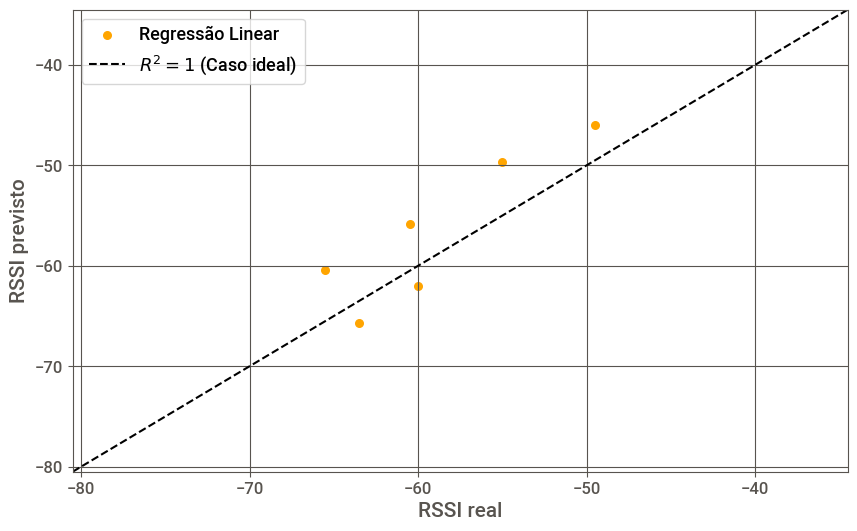

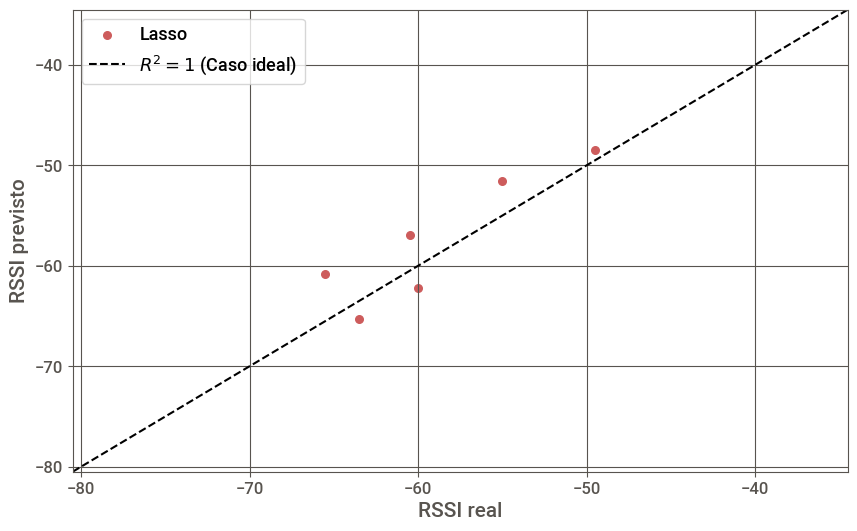

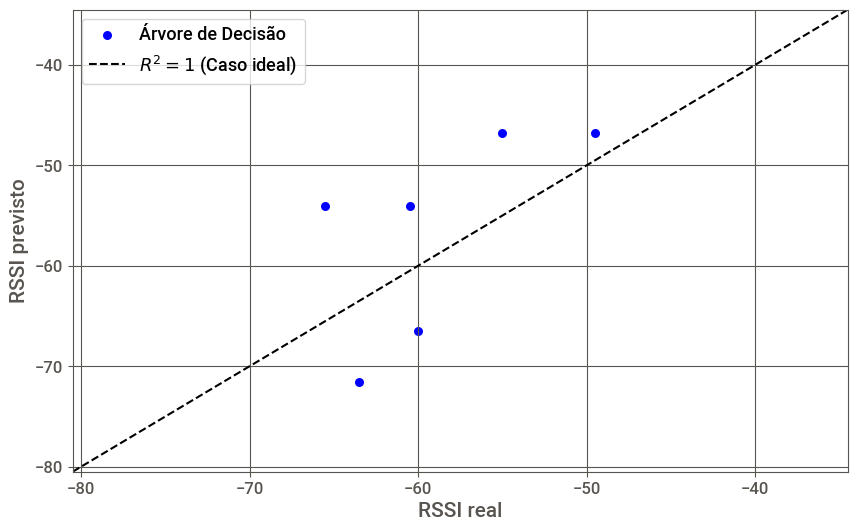

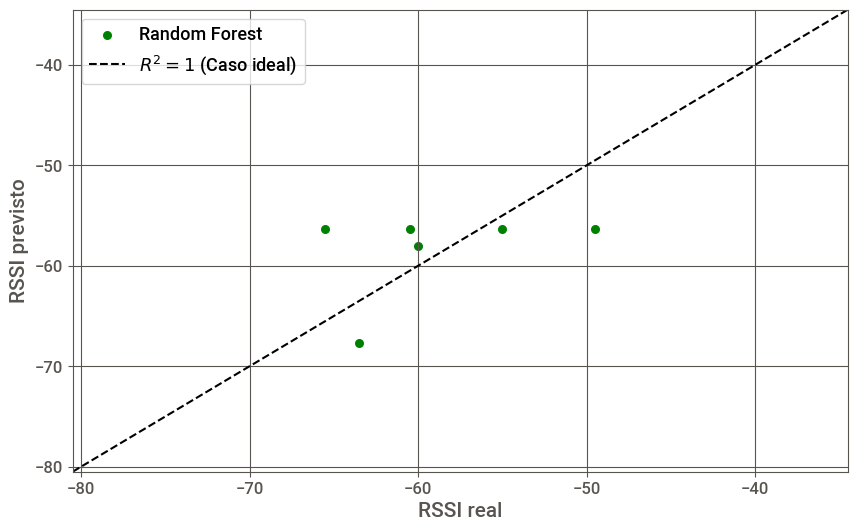

Saving figure 2-R2_Linear_Model
Saving figure 3-R2_Lasso_Model
Saving figure 3-R2_Decision_Tree_Model
Saving figure 4-R2_Random_Forest_Model


<Figure size 640x480 with 0 Axes>

In [505]:
# Plot the R2

def plot_r2(y_test, model_prediction, model_name, color='blue'):
    
    min_rssi_axis = min(y_test)-15
    max_rssi_axis = max(y_test)+15

    # Values of the RSSI to create the line of the R2=1 which is the ideal value
    rssi_values = np.linspace(min_rssi_axis, max_rssi_axis, 30)
    
    figure = plt.figure(figsize=(10,6))
    plt.scatter(y_test, model_prediction, marker='o', s=30, color=color, label=model_name)
    plt.plot(rssi_values, rssi_values, color='black', linestyle='--', label=r'$R^2=1$ (Caso ideal)')
    plt.xlabel('RSSI real', fontsize=15)
    plt.ylabel('RSSI previsto', fontsize=15)
    plt.legend(loc='best', fontsize=13)
    plt.xlim(min_rssi_axis, max_rssi_axis)
    plt.ylim(min_rssi_axis, max_rssi_axis)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.grid()
    plt.show()

    return figure


# Plot the R2 of the Linear Model
fig_r2_lin_reg = plot_r2(y_test, lin_reg_prediction, 'Regressão Linear', color='orange')
# Plot the R2 of the Lasso Model
fig_r2_lasso_reg = plot_r2(y_test, lasso_reg_prediction, 'Lasso', color='indianred')
# Plot the R2 of the Decision Tree Model
fig_r2_tree_reg = plot_r2(y_test, tree_reg_prediction, 'Árvore de Decisão', color='blue')
# Plot the R2 of the Random Forest Model
fig_r2_forest_reg = plot_r2(y_test, forest_reg_prediction, 'Random Forest', color='green')

# Save the figures
save_fig('2-R2_Linear_Model', fig_extension='png', resolution=300, figure=fig_r2_lin_reg)
save_fig('3-R2_Lasso_Model', fig_extension='png', resolution=300, figure=fig_r2_lasso_reg)
save_fig('3-R2_Decision_Tree_Model', fig_extension='png', resolution=300, figure=fig_r2_tree_reg)
save_fig('4-R2_Random_Forest_Model', fig_extension='png', resolution=300, figure=fig_r2_forest_reg)

## Model Persistence using Joblib

In [25]:
import joblib

def save_model(model, model_name):
    MODEL_PATH = os.path.join('models', model_name)
    joblib.dump(model, MODEL_PATH)

# Save the linear model
save_model(lin_reg, 'lin_reg.pkl')
# Save the Decision Tree model
save_model(tree_reg_best, 'tree_reg_best.pkl')
# Save the Random Forest model
save_model(forest_reg_best, 'forest_reg_best.pkl')

## RSSI Calculate with Optimized Path Loss Equation 

In [26]:
# Frequency
frequency = 5200
# Transmit power
Pt = 10 * np.log10(250) + 5 + 1
# Reference distance
d0 = 1

# Free-space path loss model
Ao = 32.44+20*np.log10(d0/1000)+20*np.log10(frequency)
# Distances
d = 10**(X_test.values)

# Obtem apenas a ultima amostra do dataset X_test
# d = X_test.values[-1]

# Optimized coefficients
n = 1.849654136491729
k = 25.764025097163724

# Optimized Path Loss
L = Ao + 10*n*np.log10(d/d0) + k

# Received Power According to the Optimized Path Loss
Pr = Pt - L

print(Pr)

[[-48.23237611]
 [-44.06597485]
 [-47.0847073 ]
 [-44.94288254]
 [-39.78232532]
 [-40.56674598]]


### Analyzing the Metrics of Optimized Path Loss Equation

In [27]:
# R^2 and RMSE of the optimized path loss
path_loss_opt_rmse = root_mean_squared_error(y_test, Pr)
path_loss_opt_mae = mean_absolute_error(y_test, Pr)
path_loss_opt_r2 = r2_score(y_test, Pr)

print(f'RMSE (Path Loss Optimized): {path_loss_opt_rmse}')
print(f'MAE (Path Loss Optimized): {path_loss_opt_mae}')
print(f'R2 (Path Loss Optimized): {path_loss_opt_r2}')

RMSE (Path Loss Optimized): 2.199444635133243
MAE (Path Loss Optimized): 2.048290021182526
R2 (Path Loss Optimized): 0.4101539667786941


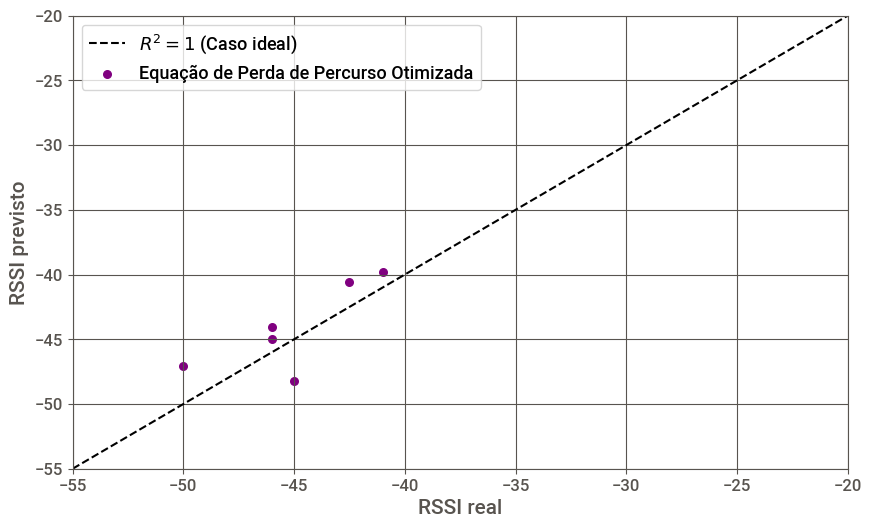

Saving figure 5-R2_Optimized_Path_Loss


<Figure size 600x400 with 0 Axes>

In [28]:
# Plot the R2 of the Optimized Path Loss
fig_r2_path_loss_loss_opt = plot_r2(y_test, Pr, 'Equação de Perda de Percurso Otimizada', color='purple')

# Save the R2 of the Optimized Path Loss
save_fig('5-R2_Optimized_Path_Loss', fig_extension='png', resolution=300, figure=fig_r2_path_loss_loss_opt)

## Saves the Metrics in a table

In [29]:
# Function to save the metrics of the models and path loss optimized equation in the test set
def save_metrics(lin_reg_rmse, lin_reg_mae, lin_reg_r2,
                            tree_reg_rmse, tree_reg_mae, tree_reg_r2,
                            forest_reg_rmse, forest_reg_mae, forest_reg_r2,
                            path_loss_opt_rmse, path_loss_opt_mae, path_loss_opt_r2,
                            filename='models_metrics_in_test_set.xlsx'):
    
    # Creates the tables folder
    os.makedirs('tables', exist_ok=True)

    METRICS_PATH = os.path.join('tables', filename)
    
    # Creates a dictionary with the metrics
    data = {
        'Model': ['Linear', 'Decision Tree', 'Random Forest','Optimized Equation'],
        'RMSE': [lin_reg_rmse, tree_reg_rmse, forest_reg_rmse, path_loss_opt_rmse],
        'MAE': [lin_reg_mae, tree_reg_mae, forest_reg_mae, path_loss_opt_mae],
        'R2': [lin_reg_r2, tree_reg_r2, forest_reg_r2, path_loss_opt_r2]
    }

    # Creates a dataframe
    df_metrics = pd.DataFrame(data)

    # Saves the dataframe in a excel file
    df_metrics.to_excel(METRICS_PATH, index=False)

    return df_metrics

df_metrics = save_metrics(lin_reg_rmse, lin_reg_mae, lin_reg_r2,
                            tree_reg_rmse, tree_reg_mae, tree_reg_r2,
                            forest_reg_rmse, forest_reg_mae, forest_reg_r2,
                            path_loss_opt_rmse, path_loss_opt_mae, path_loss_opt_r2,
                            filename='models_metrics_in_test_set.xlsx')